# End-to-end Email Spam Detection

In [1]:
# Download zip containing samples
!wget https://hr-projects-assets-prod.s3.amazonaws.com/87f90m70is5/c03f0a60c93f042665353526ddbd2e47/data.zip


--2025-03-20 21:12:51--  https://hr-projects-assets-prod.s3.amazonaws.com/87f90m70is5/c03f0a60c93f042665353526ddbd2e47/data.zip
Resolving hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)... 52.217.170.217, 16.15.176.73, 52.216.54.201, ...
Connecting to hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)|52.217.170.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40357886 (38M) [binary/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]  38.49M  62.0MB/s    in 0.6s    

2025-03-20 21:12:52 (62.0 MB/s) - ‘data.zip’ saved [40357886/40357886]



In [2]:
!unzip -q data.zip

In [3]:
# Load one sample
with open("/content/train_data/c660d514459c4bacb8e19f7faf6a9cc8") as fp:
    data = fp.read()
print(data)

Kevin Presto Presentation Tomorrow
Hello all - 

Just a reminder that tomorrow is a training session.  

Please let me know if you will not be able to attend.  

The location is 32C2 at 4-6 pm.

Thanks - 

Adrianne
x57302




Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from wordcloud import WordCloud

In [5]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
train_df = pd.read_csv('/content/train_data.csv')

First things first, let's merge the text files with corresponding IDs.

In [8]:
import os
def read_messages(uuid):
  filepath = f'/content/train_data/{uuid}'
  if os.path.exists(filepath):
        with open(filepath, 'r', encoding='utf-8') as file:
            return file.read()
  return None
# rerun for test set
train_df['message'] = train_df['uuid'].apply(read_messages)

In [9]:
train_df

,uuid,label,message
0,c660d514459c4bacb8e19f7faf6a9cc8,0,Kevin Presto Presentation Tomorrow\nHello all ...
1,9cda9659602043179fb8d22b92e0aa22,1,CNN.com Daily Top 10\n>+=+=+=+=+=+=+=+=+=+=+=+...
2,17153622763445379e0162ff1fdffa67,1,"Double Coverage Amount, Same Payment... ..."
3,150407376134498a890b7b80d6d9893e,1,CNN.com Daily Top 10\n>+=+=+=+=+=+=+=+=+=+=+=+...
4,ebc584e8e74a422f963a9fe70233bae4,0,Trade Me - A request from a Trade Me member. A...
...,...,...,...
28647,cb076324eb1a450e8f410bbe71524e71,0,Smoke [5.10.0] 32357 FAIL(F) openbsd 4.1 (i386...
28648,6583a591df05452cbbf04a40ed42ba24,0,RE: Proposed Experiment: More Meeting Time on ...
28649,de7bc2db5dac4364b6826376ba2d621c,1,CNN.com Daily Top 10\n>+=+=+=+=+=+=+=+=+=+=+=+...
28650,88ad1e7e65f14b4fb6453528ef90deb6,0,"Re: [spambayes-dev] problem in ""python setup.p..."


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28652 entries, 0 to 28651
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   uuid     28652 non-null  object
 1   label    28652 non-null  int64 
 2   message  28652 non-null  object
dtypes: int64(1), object(2)
memory usage: 671.7+ KB


## Some EDA

In [11]:
values = train_df['label'].value_counts()
total = values.sum()

percentage_0 = (values[0]/ total)*100
percentage_1 = (values[1]/total)* 100

print('percentage of 0 label: ', percentage_0)
print('percentage of 1 label: ', percentage_1)

percentage of 0 label:  62.21206198520173
percentage of 1 label:  37.787938014798264


In [12]:
values

,count
label,
0,17825
1,10827


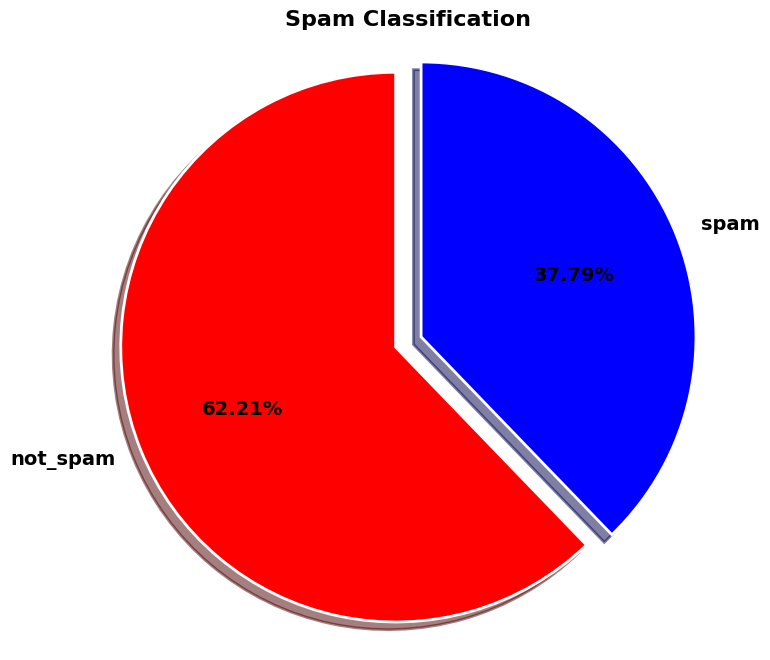

In [13]:
import matplotlib.pyplot as plt
colors = ['red','blue']
explode= (0,0.1)
fig,ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('white')
wedges, texts, autotexts = ax.pie(
    values, labels=['not_spam', 'spam'],
    autopct='%0.2f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
    explode=explode,  # Apply the explode parameter
    shadow=True  # Add shadow
)

# Customize text properties
for text, autotext in zip(texts, autotexts):
    text.set(size=14, weight='bold')
    autotext.set(size=14, weight='bold')

# Add a title
ax.set_title('Spam Classification', fontsize=16, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Show the pie chart
plt.show()

### Text length and Structure

In [14]:
train_df['num_characters'] = train_df['message'].apply(len)
train_df['num_words'] = train_df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
train_df['num_sentence'] = train_df['message'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [15]:
train_df[['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,28652.000000,28652.000000,28652.000000
mean,1949.166620,340.407895,13.518637
std,3223.588402,591.370875,20.785459
min,20.000000,2.000000,1.000000
25%,427.000000,74.000000,4.000000
50%,967.000000,187.000000,8.000000
75%,2386.000000,420.000000,16.000000
max,65086.000000,12724.000000,664.000000


### Stats for legitimate emails

In [16]:
train_df[train_df['label']==0][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,17825.000000,17825.000000,17825.000000
mean,2329.414698,439.715512,15.058401
std,3801.961117,708.969205,24.002436
min,26.000000,2.000000,1.000000
25%,715.000000,137.000000,5.000000
50%,1242.000000,245.000000,9.000000
75%,2382.000000,452.000000,16.000000
max,65086.000000,12724.000000,553.000000


### Stats for spam emails

In [17]:
train_df[train_df['label']==1][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,10827.000000,10827.000000,10827.000000
mean,1323.146301,176.913088,10.983652
std,1752.852765,234.555051,13.584101
min,20.000000,2.000000,1.000000
25%,206.000000,36.000000,2.000000
50%,459.000000,70.000000,6.000000
75%,2420.000000,411.500000,15.000000
max,52061.000000,10750.000000,664.000000


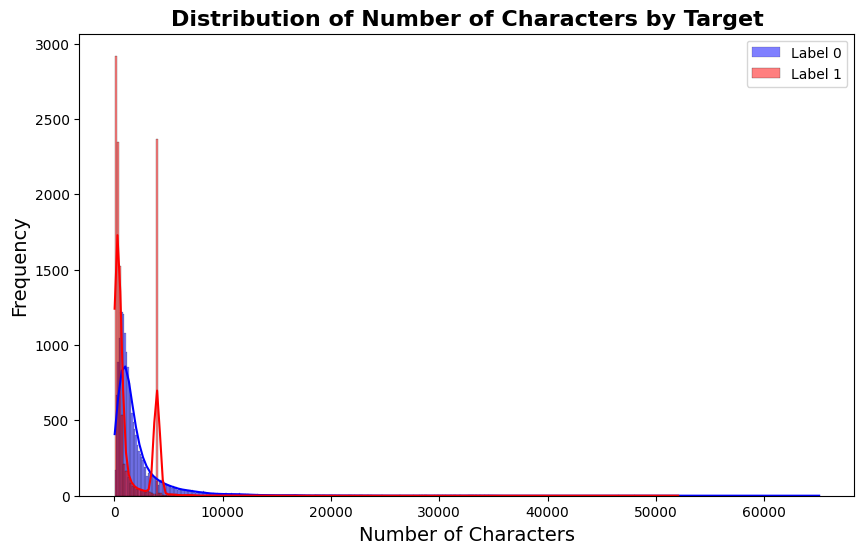

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# label 0 in blue
sns.histplot(train_df[train_df['label'] == 0]['num_characters'], color='blue', label='Label 0', kde=True)
# label 1 in red
sns.histplot(train_df[train_df['label'] == 1]['num_characters'], color='red', label='Label 1', kde=True)

plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Characters by Target', fontsize=16, fontweight='bold')
plt.legend()
sns.set(style='whitegrid')
plt.show()

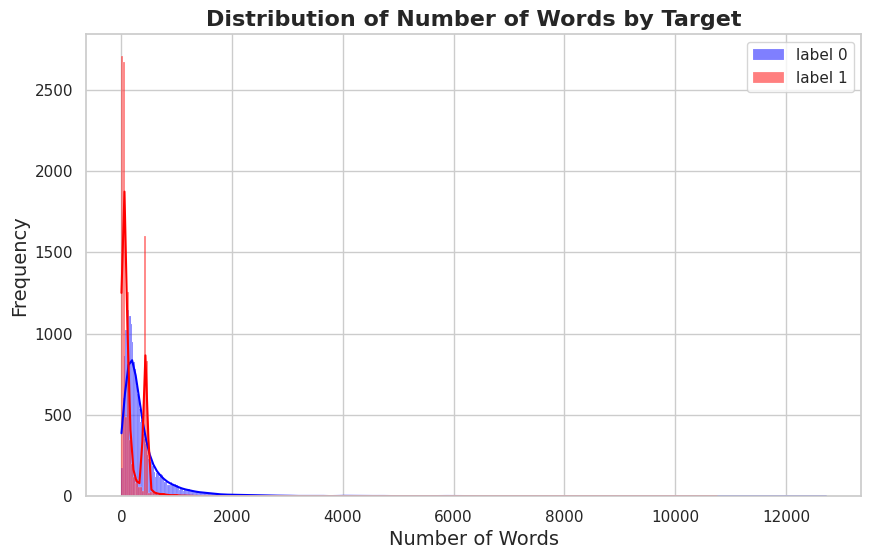

In [19]:
plt.figure(figsize=(10, 6))

sns.histplot(train_df[train_df['label'] == 0]['num_words'], color='blue', label='label 0', kde=True)

sns.histplot(train_df[train_df['label'] == 1]['num_words'], color='red', label='label 1', kde=True)

plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Words by Target', fontsize=16, fontweight='bold')
plt.legend()
sns.set(style='whitegrid')

plt.show()

In [20]:
train_df[['label','num_characters', 'num_words', 'num_sentence']].corr()

,label,num_characters,num_words,num_sentence
label,1.000000,-0.151355,-0.215472,-0.095052
num_characters,-0.151355,1.000000,0.964428,0.844460
num_words,-0.215472,0.964428,1.000000,0.848857
num_sentence,-0.095052,0.844460,0.848857,1.000000


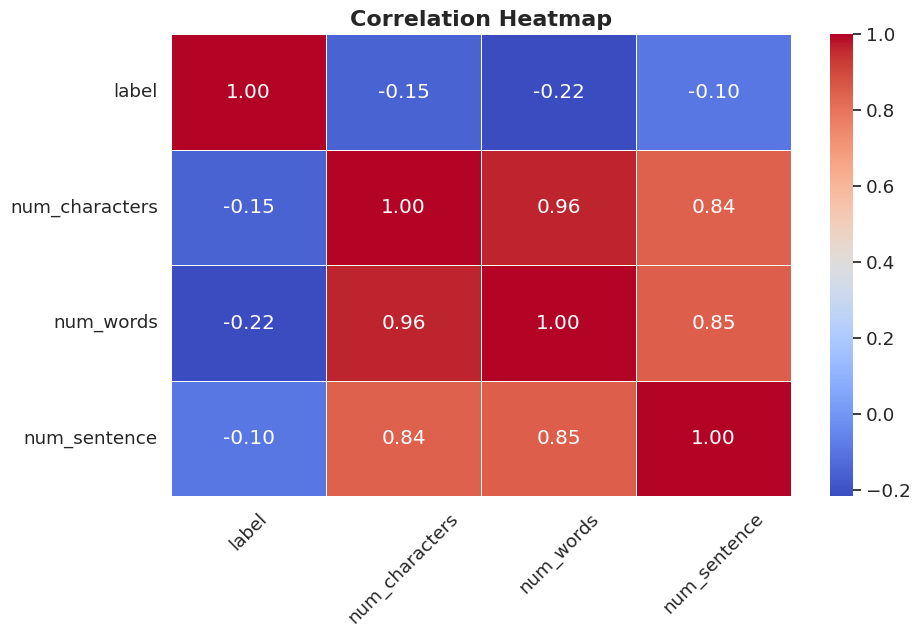

In [21]:
correlation_matrix = train_df[['label', 'num_characters', 'num_words', 'num_sentence']].corr()

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

## Little preprocessing

In [22]:
from nltk.stem.porter import PorterStemmer
import string
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    return " ".join(y)

In [23]:
train_df['processed_text'] = train_df['message'].apply(transform_text)

In [24]:
train_df

,uuid,label,message,num_characters,num_words,num_sentence,processed_text
0,c660d514459c4bacb8e19f7faf6a9cc8,0,Kevin Presto Presentation Tomorrow\nHello all ...,223,42,4,kevin presto present tomorrow hello remind tom...
1,9cda9659602043179fb8d22b92e0aa22,1,CNN.com Daily Top 10\n>+=+=+=+=+=+=+=+=+=+=+=+...,3916,441,31,daili top 10 daili top 10 top video stori aug ...
2,17153622763445379e0162ff1fdffa67,1,"Double Coverage Amount, Same Payment... ...",747,157,6,doubl coverag amount payment uyz save 75 term ...
3,150407376134498a890b7b80d6d9893e,1,CNN.com Daily Top 10\n>+=+=+=+=+=+=+=+=+=+=+=+...,3919,420,28,daili top 10 daili top 10 top video stori aug ...
4,ebc584e8e74a422f963a9fe70233bae4,0,Trade Me - A request from a Trade Me member. A...,372,71,2,trade request trade member auction 129227503 t...
...,...,...,...,...,...,...,...
28647,cb076324eb1a450e8f410bbe71524e71,0,Smoke [5.10.0] 32357 FAIL(F) openbsd 4.1 (i386...,6813,1368,6,smoke 32357 fail f openbsd cpu autom smoke rep...
28648,6583a591df05452cbbf04a40ed42ba24,0,RE: Proposed Experiment: More Meeting Time on ...,426,71,5,propos experi meet time friday ietf 73 david s...
28649,de7bc2db5dac4364b6826376ba2d621c,1,CNN.com Daily Top 10\n>+=+=+=+=+=+=+=+=+=+=+=+...,3919,420,28,daili top 10 daili top 10 top video stori aug ...
28650,88ad1e7e65f14b4fb6453528ef90deb6,0,"Re: [spambayes-dev] problem in ""python setup.p...",790,126,5,problem python build chinmaye nagaraju wrote d...


Most frequently used spam messages

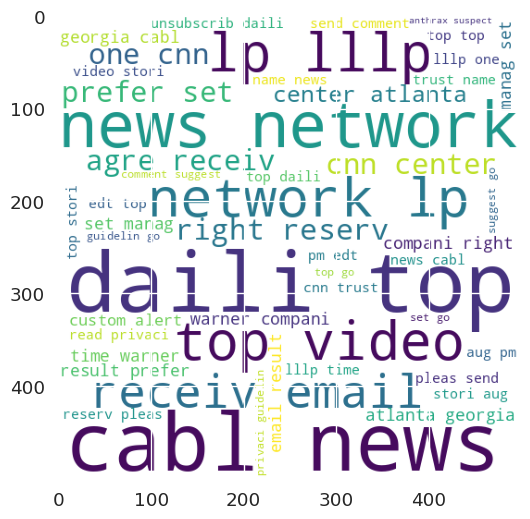

In [25]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(train_df[train_df['label'] == 1]['processed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()

Most frequently words in not spam messages

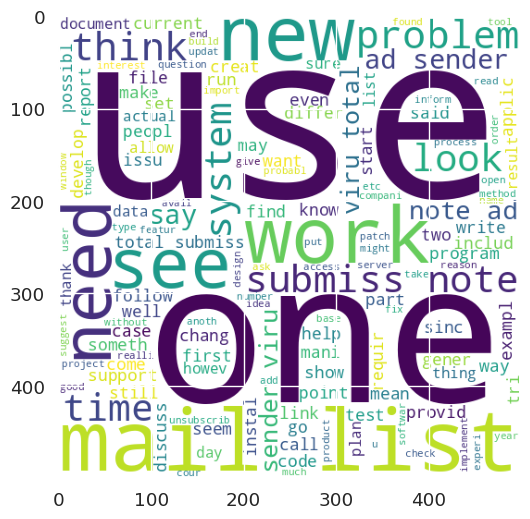

In [26]:
not_spam_wc = wc.generate(train_df[train_df['label'] == 0]['processed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()

## Modelling

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfid = TfidfVectorizer(max_features = 3000)

In [28]:
X = tfid.fit_transform(train_df['processed_text']).toarray()
y = train_df['label'].values

Split data into train and test set
* 80% train
* 20% test

In [29]:
from sklearn.model_selection import train_test_split,cross_val_score
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Import the models

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import RocCurveDisplay

Dictionary of the models

In [31]:
models = {"Logistic Regressiom":LogisticRegression(),
          "KNN":KNeighborsClassifier(),
          "RandomForest":RandomForestClassifier(),
          "MultinomialNB":MultinomialNB()}

Function to fit and score models:

In [32]:
def fit_and_score(models,X_train,X_test,y_train,y_test):
    """ Fits and evaluates given ML models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : testing labels
    """
    # set random seed
    np.random.seed(42)
    # make a dictionary to keep model scores
    model_scores={}
    # loop through models
    for name,model in models.items():
        # fit the model to the data
        model.fit(X_train,y_train)
        # evaluate the model and append its score to model_scores
        model_scores[name]=model.score(X_test,y_test)
    return model_scores

In [33]:
model_scores = fit_and_score(models=models,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
model_scores

{'Logistic Regressiom': 0.9759204327342523,
 'KNN': 0.6328738440062817,
 'RandomForest': 0.970860233816088,
 'MultinomialNB': 0.9085674402373058}

### Model comparison

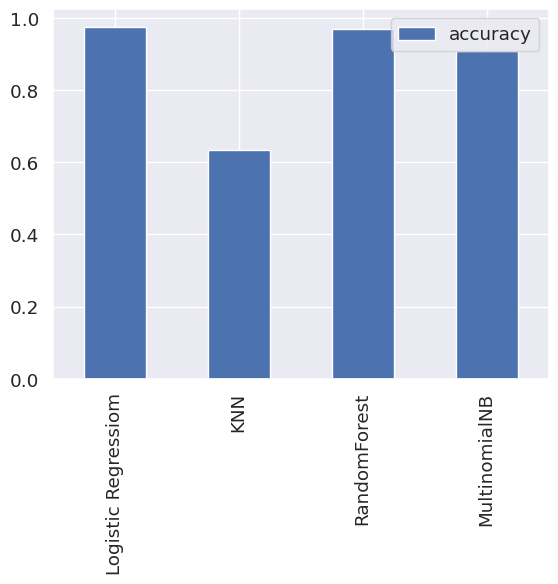

In [34]:
model_compare = pd.DataFrame(model_scores,index=["accuracy"])
model_compare.T.plot.bar();

Now we got a baseline model, we should look after the following:
* hyperparameter tuning
* feature importance
* confusion matrix


## Hyperparameter tuning with RandomizedSearchCV

We're going to tune:

* `LogisticRegression()`
* `RandomForestClassifier()`

In [35]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4,4,20),"solver":["liblinear"]}

# Create hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10,1000,50),
           "max_depth":[None,3,5,10],
           "min_samples_split":np.arange(2,20,2),
           "min_samples_leaf":np.arange(1,20,2)}

In [36]:
# Tune LogisticRegression

np.random.seed(42)

#Setup random Hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),param_distributions=log_reg_grid,cv=5,n_iter=20,verbose=True)

#Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [37]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': np.float64(11.288378916846883)}

In [38]:
rs_log_reg.score(X_test,y_test)

0.9829000174489618

Now we tuned LogisticRegression let's do the same for `RandomForestClassifier()`

In [39]:
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf=RandomizedSearchCV(RandomForestClassifier(),param_distributions=rf_grid,cv=5,n_iter=20,verbose=True)

#Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [40]:
# Find the best hyperparameters
rs_rf.best_params_

{'n_estimators': np.int64(510),
 'min_samples_split': np.int64(14),
 'min_samples_leaf': np.int64(1),
 'max_depth': None}

In [41]:
# Evaluate the randomized search RandomForestClassifier model
rs_rf.score(X_test,y_test)

0.970162275344617

## Hyperparameters Tuning using GridSearchCV
Since our LogisticRegression model provides the best scores so far we'll try and improve them againg using GridSearchCV

In [56]:
# Different HyperParameters for our LogisticRegression model
log_reg_grid = {"C":np.logspace(-4,4,30),
                "solver":["liblinear"]}

#Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [57]:
# Check the best hyperparameters
gs_log_reg.best_params_

{'C': np.float64(9.236708571873866), 'solver': 'liblinear'}

In [58]:
# Evaluate the grid search LogisticRegression model
gs_log_reg.score(X_test,y_test)

0.982725527831094

## Evaluating our tuned machine learning classifier , beyond accuracy
* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1- score

... and it would be great if cross-validation was used where possible

To make comparisons and evaluate our trained model, first we need to make predictions.

In [59]:
# Make predictions with tuned model
y_preds= gs_log_reg.predict(X_test)

In [60]:
y_preds

array([0, 1, 1, ..., 1, 1, 0])

In [61]:
y_test

array([0, 1, 1, ..., 1, 1, 0])

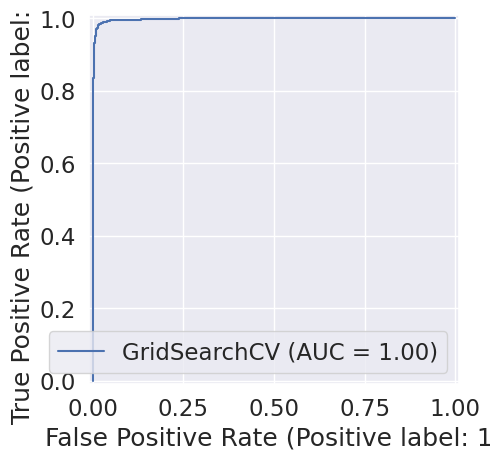

In [62]:
# Plot ROC curve and calculate AUC metric
RocCurveDisplay.from_estimator(gs_log_reg,X_test,y_test)

## Confusion matrix

In [42]:
# Make predictions with tuned model
y_preds= rs_log_reg.predict(X_test)

In [43]:
y_preds

array([0, 1, 1, ..., 1, 1, 0])

In [44]:
# Confusion matrix
print(confusion_matrix(y_test,y_preds))

[[3454   48]
 [  50 2179]]


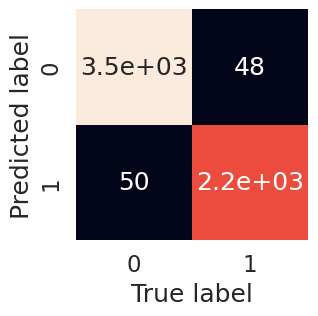

In [45]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test,y_preds):
    """
    Plots a nice looking confusion matrix using Seaborns's heatmap
    """
    fig,ax = plt.subplots(figsize=(3,3))
    ax=sns.heatmap(confusion_matrix(y_test,y_preds),annot=True,cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")

plot_conf_mat(y_test,y_preds)

In [46]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3502
           1       0.98      0.98      0.98      2229

    accuracy                           0.98      5731
   macro avg       0.98      0.98      0.98      5731
weighted avg       0.98      0.98      0.98      5731



## Calculate evaluation matrix using cross_validation
We're going to calculate precision, recall and f1-score of our model using cross-validation and to do so we'll be using `cross_val_score()`.

In [63]:
# Check best hyperparameters
gs_log_reg.best_params_

{'C': np.float64(9.236708571873866), 'solver': 'liblinear'}

In [65]:
# Create a new classifier with best parameters
clf= LogisticRegression(C=np.float64(9.236708571873866),solver="liblinear")

In [66]:
# Cross-validated accuracy

cv_acc = cross_val_score(clf,X,y,cv=5,scoring="accuracy")
cv_acc

array([0.98237655, 0.98237655, 0.98097731, 0.98132635, 0.98272251])

In [67]:
cv_acc = np.mean(cv_acc)
cv_acc

np.float64(0.9819558550402376)

In [68]:
# Cross-validated precision
cv_precision = cross_val_score(clf,X,y,cv=5,scoring="precision")
cv_precision = np.mean(cv_precision)
cv_precision

np.float64(0.9774141804584489)

In [69]:
# Cross-validated recall
cv_recall = cross_val_score(clf,X,y,cv=5,scoring="recall")
cv_recall= np.mean(cv_recall)
cv_recall

np.float64(0.9747847801099929)

In [70]:
# Cross-validated f1-score
cv_f1 = cross_val_score(clf,X,y,cv=5,scoring="f1")
cv_f1= np.mean(cv_f1)
cv_f1

np.float64(0.9760915447732945)

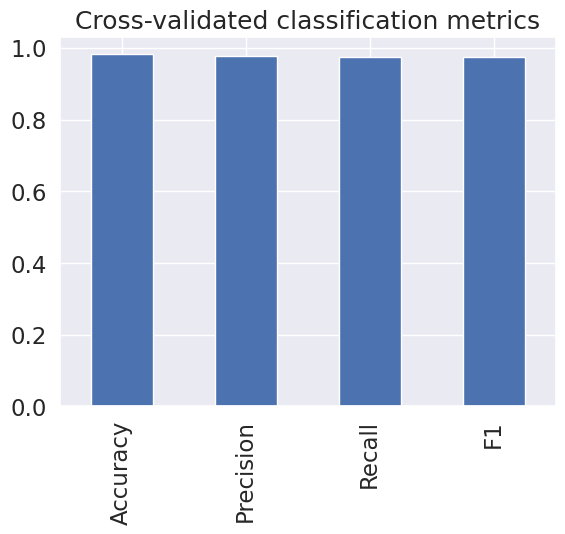

In [71]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy":cv_acc,
                           "Precision":cv_precision,
                           "Recall":cv_recall,
                           "F1":cv_f1},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-validated classification metrics",legend=False);

In [51]:
test_df = pd.read_csv('/content/test_data.csv')

In [52]:
import os
def read_test_messages(uuid):
  filepath = f'/content/test_data/{uuid}'
  if os.path.exists(filepath):
        with open(filepath, 'r', encoding='utf-8') as file:
            return file.read()
  return None

test_df['message'] = test_df['uuid'].apply(read_test_messages)

In [53]:
test_df

,uuid,message
0,17d6fd8590314de89c56dd764a96e149,ANN: Leo 4.4.8 rc1 released\nLeo 4.4.8 rc1 is ...
1,2adf73fc065c4ed9b1294b1d6ab9d2b4,CNN.com Daily Top 10\n>+=+=+=+=+=+=+=+=+=+=+=+...
2,716faf55939e4e22952262fd433e2203,[UAI] Announcement and CFP: Natural Language a...
3,6adaf8c793c843b7936423484f28b1a1,Offer variety replica watches\n\nReplica Class...
4,12000b7523164ae48822553ea70e5927,Re: Where to get the latest PGP FAQ\n............
...,...,...
7158,ebf27d1a2ac442e28cb5fb4fe9cb5c12,Re: [Python-Dev] Py3k and asyncore/asynchat\nA...
7159,c656180440ef46e0b96b356ae9af6afc,fashionable replica watches\n\nBest IWC replic...
7160,8ffb3a5d61bf4322b2c1051fa8806bb0,"Re: 5.10 build failure on Debian.\nOn Wed, Nov..."
7161,6906304618894f44b7195edbd225b12a,Raw video of Paris k\n Imagine if you cou...


In [54]:
test_df['processed_text'] = test_df['message'].apply(transform_text)

In [74]:
test_df['num_characters'] = test_df['message'].apply(len)
test_df['num_words'] = test_df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
test_df['num_sentence'] = test_df['message'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [75]:
X = tfid.fit_transform(test_df['processed_text']).toarray()

In [77]:
predictions = gs_log_reg.predict(X)

In [78]:
test_df['label']= predictions
test_df

,uuid,message,processed_text,num_characters,num_words,num_sentence,label
0,17d6fd8590314de89c56dd764a96e149,ANN: Leo 4.4.8 rc1 released\nLeo 4.4.8 rc1 is ...,ann leo rc1 releas leo rc1 avail http version ...,1691,302,10,0
1,2adf73fc065c4ed9b1294b1d6ab9d2b4,CNN.com Daily Top 10\n>+=+=+=+=+=+=+=+=+=+=+=+...,daili top 10 daili top 10 top video stori aug ...,3923,446,33,0
2,716faf55939e4e22952262fd433e2203,[UAI] Announcement and CFP: Natural Language a...,uai announc cfp natur languag knowledg represe...,6817,1198,35,0
3,6adaf8c793c843b7936423484f28b1a1,Offer variety replica watches\n\nReplica Class...,offer varieti replica watch replica classic st...,215,27,1,1
4,12000b7523164ae48822553ea70e5927,Re: Where to get the latest PGP FAQ\n............,get latest pgp faq follow faq kept ftp ftp pgp...,383,61,2,0
...,...,...,...,...,...,...,...
7158,ebf27d1a2ac442e28cb5fb4fe9cb5c12,Re: [Python-Dev] Py3k and asyncore/asynchat\nA...,py3k far tell updat good use earlier variant p...,1440,257,9,0
7159,c656180440ef46e0b96b356ae9af6afc,fashionable replica watches\n\nBest IWC replic...,fashion replica watch best iwc replica watch r...,211,26,1,0
7160,8ffb3a5d61bf4322b2c1051fa8806bb0,"Re: 5.10 build failure on Debian.\nOn Wed, Nov...",build failur debian wed nov 14 2007 david cant...,663,135,5,0
7161,6906304618894f44b7195edbd225b12a,Raw video of Paris k\n Imagine if you cou...,raw video pari k imagin could add inch girth o...,135,25,2,0


In [79]:
test_df['label'].value_counts()

,count
label,
0,5818
1,1345


In [80]:
test_df.to_csv('predictions.csv', index=False)